In [2]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy
from collections import OrderedDict
import random
import csv
import numpy as np
import time

In [3]:
%load_ext PWE_NB_Extension

In [4]:
def turn_list_into_str(l):
    # small bug fix 
    if isinstance(l, (list,set,frozenset)):
        if len(l) > 1:
            l_ = [turn_list_into_str(l1) for l1 in l[1:]]
            return "{}({})".format(l[0], ",".join(l_))
        elif len(l) == 1:
            return "{}".format(l[0])
        else:
            return ""
    else:
        return l


In [5]:
def sql2clingo(sqlCommand,originalSchema,colour='black'):
    '''Generate all possible SQL commands on a given dataset in datalog format
    
    :param sqlCommand: Type of query to generate
    :param originalSchema: Shape of datalog fact database
    :param colour: Edge colour for transformation
    :return clingoString: Set of chosen SQL commands in datalog
    '''
    sql = sqlCommand.replace('"','')
    sqlList = sql.split(' ') 
    #print(sqlList)
    schemaList = originalSchema.split(',')
    #print(schemaList)
    clingoString = 0
    #print(sqlList[0])
    if sqlList[0] == 'UPDATE':
        sql = sql.replace(' = ','=')
        sql = sql.replace(' > ','>')
        sql = sql.replace(' < ','<')
        sql = sql.replace(' >= ','>=')
        sql = sql.replace(' <= ','<=')
        sql = sql.replace(',','')
        sqlList = sql.split(' ') 
        setLoc = sqlList.index('SET')
        whereLoc = sqlList.index('WHERE')
        setCommands = sqlList[setLoc+1:whereLoc]
        setCommands = [x.upper() for x in setCommands]
        whereCommands = sqlList[whereLoc+1:]
        whereCommands = [x.upper() for x in whereCommands if x != 'AND']
        whereCommandsString = '-'.join(whereCommands)
        whereCommandsComma = ','.join(whereCommands)
        setLocs = [x[:x.index('=')] for x in setCommands]
        setValues = [x[x.index('=')+1:] for x in setCommands]
        setVals = []
        startSetVals = []
        for x in (schemaList):
            if x in setLocs:
                loc = setLocs.index(x)
                setVals.append(setValues[loc])
                startSetVals.append('_')
            else:
                setVals.append(x)
                startSetVals.append(x)
        setValsString = ','.join(setVals)
        #clingoString = 'data('+setValsString+',black,"'+whereCommandsString+'",'+originalSchema+') :- data('+originalSchema+',_,_,_,_,_,_,_,_,_),'+whereCommandsComma+'.'
        clingoString = 'e(data('+setValsString+'),data1('+originalSchema+',P,N0),trans('+colour+',"'+whereCommandsString+'")) :- data1('+originalSchema+',P,N0),'+whereCommandsComma+'.'
    if sqlList[0] == 'INSERT':
        locator = 'VALUES('
        loc1 = sql.index(locator)
        loc2 = sql[loc1:].index(')')+loc1
        datavalues = sql[loc1+len(locator):loc2]
        datavaluesDash = datavalues.replace(',','-')
        clingoString = 'data1('+datavalues+',"INSERT'+datavaluesDash+'",0).'
    
    return clingoString

In [6]:
def makeOriginal(dataValues,colour='black'):
    '''Transform original data into a datalog fact database
    
    :param dataValues: Original data set in list format
    :param colour: Obselete parameter can be removed - probably
    :return clingoStart: Fact database of original data
    '''
    clingoStart = []
    for x in dataValues:
        clingoStart.append('data1('+','.join(x)+',"",0).')
    return clingoStart

In [7]:
def addConversion(dataValues):
    '''Generate conversion of edge to nodes in datalog
    
    :param dataValues: Original data set in list format
    :return clingoHead+clingoBody: Datalog edge transformation
    '''
    variables = []
    #spaces = ['_']*len(dataValues)
    #underscores = ','.join(spaces)
        
    variables = [chr(65+x) for x in range(len(dataValues))]
    varLen = len(variables)
    variables2 = [chr(65+x+varLen) for x in range(len(dataValues))]
    clingoHead = 'data1('+','.join(variables)+',prov(P,T),N1) :- '
    clingoBody = 'e(data('+','.join(variables)+'),data1('+','.join(variables2)+',P,N0),trans(_,T)), N1=N0+1, depth(N0).'
    
    return clingoHead+clingoBody

In [8]:
def newAddConversion(dataValues):
    '''Generate conversion between two separate fact databases
    
    :param dataValues: Original data set in list format
    :return clingoHead+clingoBody: Datalog transformation between two fact databases
    '''
    variables = [chr(65+x) for x in range(len(dataValues))]
    clingoHead = 'data('+','.join(variables)+') :- '
    clingoBody = 'data1('+','.join(variables)+',_,_).'
    return clingoHead+clingoBody

In [9]:
def addDepth(depthSize):
    '''Generate depth size, used to determine the number of allowed itterations without going infinite
    
    :param depthSize: Intended number of itterations
    :return depth: Datalog code for depth  
    '''
    depth = 'depth(0..{}).'.format(depthSize)
    return depth

In [10]:
def smallConvert(string):
    b = string.replace('data(','')
    b = b[:-1]
    c = b.replace('),',')\n')
    return c

In [11]:
def cleanCSVFile(csv,outCSV):
    # nothing important, just reformatting for the remaining code
    with open(csv,'r') as f:
        data = f.read()
    dataNew = data.replace('(','')
    dataNew2 = dataNew.replace(')','')
    with open(outCSV,'w') as f:
        f.write(dataNew2)
    print(dataNew2)

In [12]:
def createProv(dataendRow,lenOriginalSchema=7):
    # another reformatting function
    #print(dataendRow)
    string = dataendRow
    loc = 0
    for x in range(lenOriginalSchema):
        loc = string.find(',')+1
        string = string[loc:]
        
    #newString = string
    loc2 = string.rfind(',')
    string = string[:loc2]
    return string

In [13]:
createProv('data1(10,82,61,46,75,28,53,prov(prov("INSERT10-82-4-4-63-28-53","A4>=19-A4<29-A2>=2-A2<10"),"A1>=2-A1<12-A4>=20-A4<30"),2)')

'prov(prov("INSERT10-82-4-4-63-28-53","A4>=19-A4<29-A2>=2-A2<10"),"A1>=2-A1<12-A4>=20-A4<30")'

In [305]:
def getGraphStats(G,target,start):
    '''Calculate stats for the graph between two nodes 
    
    :param G: Input DiGraph  
    :param target: Target node to calculate paths to
    :param: start: Start node for the graph
    :return: [APP,DIFFNUM,smallpp]: [# of all possible paths, # of difference invarience paths, size of smallest possible path]
    '''
    allPaths = []
    #for sources in dataValuesNonStr:
    singlePath = []
    for path in nx.all_simple_paths(G,source=start,target=target):
        singlePath.append(path)
    
    APP = len(singlePath)
    #print(len(allPaths))
    allPSorted = sorted(singlePath)
    allPSet = set(frozenset(x) for x in allPSorted)
    DIFF = [list(x) for x in allPSet]
    DIFFNUM = len(DIFF)
    
    minPath = nx.shortest_path(G,start,target)
    smallpp = len(minPath)
    #bigpp = nx.dag_longest_path_length(G)
    
    return [APP,DIFFNUM,smallpp]#,bigpp]

In [15]:
def createProvNew(startingProv,transCell):
    # reformatting
    loc1 = transCell.index(',') +1
    loc2 = transCell.index(')')
    trans = transCell[loc1:loc2]
    
    prov = 'prov({},{})'.format(startingProv,trans)
    
    return prov

In [16]:
names = 'nodeNum,edgeNum,insertQueries,updateQueries,longPath,smallPath,medianPath'

In [17]:
originalSchema = 'id,a0,a1,a2,a3,a4,a5'.upper()

In [18]:
testDataNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows1000_Nqueries10.csv']
testQueryNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries20.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries30.csv']

In [19]:
testDataNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries10.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries20.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries30.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows50_Nqueries10.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows50_Nqueries20.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows50_Nqueries30.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries10.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries20.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries30.csv']
testQueryNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries20.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries30.csv']


In [20]:
testDataNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows50_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries10.csv']

In [21]:
testData = '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows50_Nqueries10S.csv'
testQueries = '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows50_Nqueries10.csv'

In [1415]:
timings = []

In [1503]:
testData = ''
#testQueries = '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries10Save.csv'
#testQueries = '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries20Save.csv'
testQueries = '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries30Save.csv'
testData = testDataNames[0]
#testData = testDataNames[1]
#testData = testDataNames[2]

In [1504]:
t0 =time.time()
# testData = testDataNames[0]
# testQueries = testQueryNames[2]
testDataOG = testData
cleanCSVFile(testData,'testData.csv')
testData = 'testData.csv'

0, 13, 85, 77, 27, 52, 48
1, 65, 79, 11, 5, 85, 46
2, 76, 1, 46, 73, 26, 95
3, 91, 4, 4, 56, 95, 41
4, 21, 43, 4, 24, 46, 52
5, 23, 24, 23, 48, 32, 7
6, 84, 56, 65, 21, 100, 87
7, 12, 34, 73, 72, 94, 45
8, 83, 68, 32, 60, 89, 86
9, 51, 59, 5, 26, 81, 44


In [1505]:
projectCommand = 'e(data(A,B,C,D,E,F,G),data1(A,B,C,D,E,F,G,P,N0),trans("blue","SELECTA")) :- data1(A,B,C,D,E,F,G,P,N0).'    

In [1506]:
# code to combine datalog strings
dataSet = []
with open(testData,'r') as csvfile:
    reader = csv.reader(csvfile,delimiter=' ',quotechar='|')
    for row in reader:
        dataSet.append([' '.join(row)])

originalSetup = makeOriginal(dataSet)

with open(testQueries,'r') as f:
    data = f.read()
#print(data)    
queries = data.split('\n')
#print(queries)

commands = []
for x in queries:
    clingoString = sql2clingo(x,originalSchema)
    if clingoString != 0:
        commands.append(clingoString)
        
edgeNodeConv = addConversion(originalSchema.split(','))
nodeNodeConv = newAddConversion(originalSchema.split(','))
depth = addDepth(3)

clingo_rules = ['% schema data1('+originalSchema+',prov,NUM)','% schema e(DATAEND,DATASTART,TRANS)', '% schema data('+originalSchema+')']
clingo_rules.extend(originalSetup)
clingo_rules.extend([depth])
clingo_rules.extend([nodeNodeConv])
clingo_rules.extend(commands)
#clingo_rules.extend([projectCommand])
clingo_rules.extend([edgeNodeConv])



In [1507]:
ASPRules('\n'.join(commands)) # display transformations in datalog format

'e(data(ID,A0,95,91,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=3-A5=2")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=3,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=38,A1<48,A4>=2,A4<12.\ndata1(10,44,50,23,23,22,46,"INSERT10-44-50-23-23-22-46",0).\ndata1(11,2,84,56,64,18,100,"INSERT11-2-84-56-64-18-100",0).\ne(data(ID,A0,33,72,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=71-A5=94")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=68-A5=37")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=35,A1<45,A4>=44,A4<54.\ndata1(12,4,71,99,59,39,17,"INSERT12-4-71-99-59-39-17",0).\ne(data(ID,A0,77,54,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=78-A1<88-A4>=21-A4<31")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=78,A1<88,A4>=21,A4<31.\ne(data(ID,A0,58,46,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=24-A1<34-A4>=49-A4<59")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=24,A1<34,A4>=49,A4<59.\ne(data(ID,A0,79,82,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=89-A5=74")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=89,A5=74.\ne(data(ID,A0,56,43,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=5-A1<15-A4>=79-A4<89")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=5,A1<15,A4>=79,A4<89.\ne(data(ID,A0,50,48,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=36-A5=34")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=36,A5=34.\ne(data(ID,A0,61,46,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=2-A1<12-A4>=20-A4<30")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=2,A1<12,A4>=20,A4<30.\ndata1(13,59,86,80,80,82,25,"INSERT13-59-86-80-80-82-25",0).\ne(data(ID,A0,8,1,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=1-A1<11-A4>=68-A4<78")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=1,A1<11,A4>=68,A4<78.\ndata1(14,11,63,34,7,16,53,"INSERT14-11-63-34-7-16-53",0).\ndata1(15,27,71,45,32,47,2,"INSERT15-27-71-45-32-47-2",0).\ne(data(ID,A0,18,10,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=90-A5=51")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=90,A5=51.\ndata1(16,61,82,2,1,14,72,"INSERT16-61-82-2-1-14-72",0).\ndata1(17,71,68,55,22,98,80,"INSERT17-71-68-55-22-98-80",0).\ne(data(ID,A0,65,39,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=58-A5=32")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=58,A5=32.\ne(data(ID,A0,30,97,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=88-A5=30")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=88,A5=30.\ne(data(ID,A0,94,75,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=42-A5=25")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=42,A5=25.\ndata1(18,88,3,82,97,57,17,"INSERT18-88-3-82-97-57-17",0).\ne(data(ID,A0,71,51,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=34-A1<44-A4>=31-A4<41")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=34,A1<44,A4>=31,A4<41.\ndata1(19,68,43,19,10,67,29,"INSERT19-68-43-19-10-67-29",0).\ne(data(ID,A0,88,90,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=1-A5=20")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=1,A5=20.\ne(data(ID,A0,95,55,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1=3-A5=3")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1=3,A5=3.\ne(data(ID,A0,38,21,A3,A4,A5),data1(ID,A0,A1,A2,A3,A4,A5,P,N0),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data1(ID,A0,A1,A2,A3,A4,A5,P,N0),A1>=38,A1<48,A4>=2,A4<12.\ndata1(10,44,50,23,23,22,46,"INSERT10

In [1508]:
#ASPRules('\n'.join(originalSetup))

In [1509]:
ASPRules(edgeNodeConv) # display edge node conversion in datalog

'data1(A,B,C,D,E,F,G,prov(P,T),N1) :- e(data(A,B,C,D,E,F,G),data1(H,I,J,K,L,M,N,P,N0),trans(_,T)), N1=N0+1, depth(N0).'

In [1510]:
#ASPRules(nodeNodeConv)

In [1511]:
#ASPRules('\n'.join(clingo_rules))

In [1512]:
%clingo -l clingo_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input # clingo analysis - see PWE tutorial

Output:


'Answer: 1\ndepth(0) depth(1) depth(2) depth(3) data1(0,13,85,77,27,52,48,"",0) data1(1,65,79,11,5,85,46,"",0) data1(2,76,1,46,73,26,95,"",0) data1(3,91,4,4,56,95,41,"",0) data1(4,21,43,4,24,46,52,"",0) data1(5,23,24,23,48,32,7,"",0) data1(6,84,56,65,21,100,87,"",0) data1(7,12,34,73,72,94,45,"",0) data1(8,83,68,32,60,89,86,"",0) data1(9,51,59,5,26,81,44,"",0) data1(10,44,50,23,23,22,46,"INSERT10-44-50-23-23-22-46",0) data1(11,2,84,56,64,18,100,"INSERT11-2-84-56-64-18-100",0) data1(12,4,71,99,59,39,17,"INSERT12-4-71-99-59-39-17",0) data1(13,59,86,80,80,82,25,"INSERT13-59-86-80-80-82-25",0) data1(14,11,63,34,7,16,53,"INSERT14-11-63-34-7-16-53",0) data1(15,27,71,45,32,47,2,"INSERT15-27-71-45-32-47-2",0) data1(16,61,82,2,1,14,72,"INSERT16-61-82-2-1-14-72",0) data1(17,71,68,55,22,98,80,"INSERT17-71-68-55-22-98-80",0) data1(18,88,3,82,97,57,17,"INSERT18-88-3-82-97-57-17",0) data1(19,68,43,19,10,67,29,"INSERT19-68-43-19-10-67-29",0) data1(10,46,32,38,90,53,56,"INSERT10-46-32-38-90-53-56",0) data1(11,2,32,13,51,100,68,"INSERT11-2-32-13-51-100-68",0) data1(12,90,80,74,91,77,79,"INSERT12-90-80-74-91-77-79",0) data1(13,88,10,52,86,24,21,"INSERT13-88-10-52-86-24-21",0) data1(14,82,15,18,69,38,4,"INSERT14-82-15-18-69-38-4",0) data1(15,34,3,45,77,74,91,"INSERT15-34-3-45-77-74-91",0) data1(16,10,45,88,12,59,39,"INSERT16-10-45-88-12-59-39",0) data1(17,56,14,5,3,16,9,"INSERT17-56-14-5-3-16-9",0) data1(18,42,53,0,3,41,11,"INSERT18-42-53-0-3-41-11",0) data1(13,88,10,52,86,73,21,"INSERT13-88-10-52-86-73-21",0) data1(10,64,87,52,74,67,6,"INSERT10-64-87-52-74-67-6",0) data1(11,6,86,99,8,80,41,"INSERT11-6-86-99-8-80-41",0) data1(12,29,77,88,4,62,4,"INSERT12-29-77-88-4-62-4",0) data1(13,7,60,3,19,41,61,"INSERT13-7-60-3-19-41-61",0) data1(14,4,87,31,96,90,38,"INSERT14-4-87-31-96-90-38",0) data1(15,62,63,6,63,47,68,"INSERT15-62-63-6-63-47-68",0) data1(16,37,60,30,38,77,2,"INSERT16-37-60-30-38-77-2",0) data1(17,43,70,10,32,33,84,"INSERT17-43-70-10-32-33-84",0) data1(18,75,84,66,52,29,34,"INSERT18-75-84-66-52-29-34",0) data1(19,6,59,28,81,4,91,"INSERT19-6-59-28-81-4-91",0) data1(10,82,4,4,63,28,53,"INSERT10-82-4-4-63-28-53",0) data1(11,33,17,46,4,70,90,"INSERT11-33-17-46-4-70-90",0) data1(12,44,13,38,97,33,0,"INSERT12-44-13-38-97-33-0",0) data1(13,17,79,36,29,9,99,"INSERT13-17-79-36-29-9-99",0) data1(14,4,49,25,100,12,53,"INSERT14-4-49-25-100-12-53",0) data1(15,42,25,89,83,50,3,"INSERT15-42-25-89-83-50-3",0) data1(16,24,21,23,87,14,5,"INSERT16-24-21-23-87-14-5",0) data1(10,82,4,93,75,28,53,prov("INSERT10-82-4-4-63-28-53","A4>=19-A4<29-A2>=0-A2<10"),1) data1(16,10,45,91,30,59,39,prov("INSERT16-10-45-88-12-59-39","A4>=52-A4<62-A2>=80-A2<90"),1) data1(18,88,3,91,30,57,17,prov("INSERT18-88-3-82-97-57-17","A4>=52-A4<62-A2>=80-A2<90"),1) data1(13,17,86,80,80,34,25,prov("INSERT13-59-86-80-80-82-25","A0>=59-A0<69-A4>=80-A4<90"),1) data1(1,17,79,11,5,34,46,prov("","A0>=59-A0<69-A4>=80-A4<90"),1) data1(10,31,4,4,63,22,53,prov("INSERT10-82-4-4-63-28-53","A0>=73-A0<83-A4>=21-A4<31"),1) data1(18,31,84,66,52,22,34,prov("INSERT18-75-84-66-52-29-34","A0>=73-A0<83-A4>=21-A4<31"),1) data1(2,31,1,46,73,22,95,prov("","A0>=73-A0<83-A4>=21-A4<31"),1) data1(10,55,32,38,90,1,56,prov("INSERT10-46-32-38-90-53-56","A0>=37-A0<47-A4>=52-A4<62"),1) data1(5,43,24,23,48,72,7,prov("","A0>=21-A0<31-A4>=27-A4<37"),1) data1(8,67,68,32,60,16,86,prov("","A0>=78-A0<88-A4>=87-A4<97"),1) data1(1,59,79,11,5,91,46,prov("","A0>=62-A0<72-A4>=84-A4<94"),1) data1(16,72,60,30,38,93,2,prov("INSERT16-37-60-30-38-77-2","A0>=35-A0<45-A4>=72-A4<82"),1) data1(18,75,47,71,52,29,34,prov("INSERT18-75-84-66-52-29-34","A4>=20-A4<30-A2>=60-A2<70"),1) data1(12,90,7,62,91,77,79,prov("INSERT12-90-80-74-91-77-79","A4>=74-A4<84-A2>=66-A2<76"),1) data1(5,23,59,65,48,32,7,prov("","A4>=28-A4<38-A2>=18-A2<28"),1) data1(16,10,46,90,12,59,39,prov("INSERT16-10-45-88-12-59-39","A4>=51-A4<61-A2>=83-A2<93"),1) data1(0,13,93,49,27,52,48,prov("","A4>=45-A4<55-A2>=75-A2<85"),1) data1(12,90,16,97,91,77,79,prov("INSERT12-90-80-74-91

In [1513]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo',internal_facts_as_string=False) # All PWE analysis - see PWE tutorial

Number of Models: 1


In [1514]:
pw_rels_dfs.keys()

dict_keys(['depth_1', 'data1_9', 'data_7', 'e_3'])

In [1515]:
pwe_e3_new_format = pw_rels_dfs['e_3'].applymap(turn_list_into_str)
pwe_data3_new_format = pw_rels_dfs['data1_9'].applymap(turn_list_into_str)

In [1516]:
# code for graph generation

start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

startNode = []
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    if len(row['prov']) == 2:
        startNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')

G = nx.DiGraph()
#start = '\n'.join(startNode) # for full db
start = 'Initial DB' # for names only

edges = []
provlist = []
num = 0
# for inserts in insertNodeList:
#     endInsert = '\n'.join(inserts)
#     G.add_edge(start,endInsert,penwidth=2,color='red')
#     edges.append((start,endInsert)) # for full values

start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

insertNodeList = []
insertNodeProv = []
nodeDict = {}
nodeNameDict = {}
insertNameDict = {}
nodeDict["start"] = [x for x in startNode]
nodeDict['""'] = [x for x in startNode]
nodeNameDict["start"] = 'Initial DB'
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    #insertBase = startNode
    if 'INSERT' in row['prov']:
        if 'prov' not in row['prov']: 
            insertNode = [x for x in startNode]
            insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
            #print(insertNode)
            insertNodeList.append(insertNode)
            insertNodeProv.append(row['prov'])
            nodeDict[row['prov']] = insertNode
            nodeNameDict[row['prov']] = 'insertView '+str(num)
            insertNameDict[row['prov']] = 'insertView '+str(num)
            num += 1
            #print(row['prov'])
#print(nodeDict)  
# for key,inserts in insertNameDict.items():
#     endInsert = inserts
#     G.add_edge(start,endInsert,penwidth=2,color='red')
#     edges.append((start,endInsert)) # for names only
    
for inserts in insertNodeList:
    #endInsert = inserts
    endInsert = '\n'.join(inserts)
    startInsertNodeNewName = '\n'.join(nodeDict['""'])
    G.add_edge(startInsertNodeNewName,endInsert,penwidth=2,color='red')
    edges.append((startInsertNodeNewName,endInsert)) # for names only 

for i, row in pw_rels_dfs['e_3'].iterrows():
    #print(startProv)
    startProv = createProv(pwe_e3_new_format['DATASTART'][i])
    #print(startProv)
    #endProv = 'prov({},{})'.format(startProv,)
    endProv = createProvNew(startProv,pwe_e3_new_format['TRANS'][i])
    #print(type(endProv))
    nodeBase = nodeDict[startProv]
    #print(nodeBase)
    ignoreRow = row['DATASTART'][1:-1]
    nodeBase = [x for x in nodeBase if x != ignoreRow]
    nodeBase.append(','.join(row['DATAEND'][1:-1]))
    nodeFinal = nodeBase
    #print(nodeFinal)
    nodeDict[endProv] = nodeFinal
    nodeNameDict[endProv] = 'Table{}'.format(i)
    #print(nodeFinal)
    finalNetworkXStartNode = '\n'.join(nodeDict[startProv])
    finalNetworkXEndNode = '\n'.join(nodeDict[endProv])
    G.add_edge(finalNetworkXStartNode,finalNetworkXEndNode ,penwidth=2,color='blue')
#     print(row['DATASTART'])
#     print(row['DATAEND'])

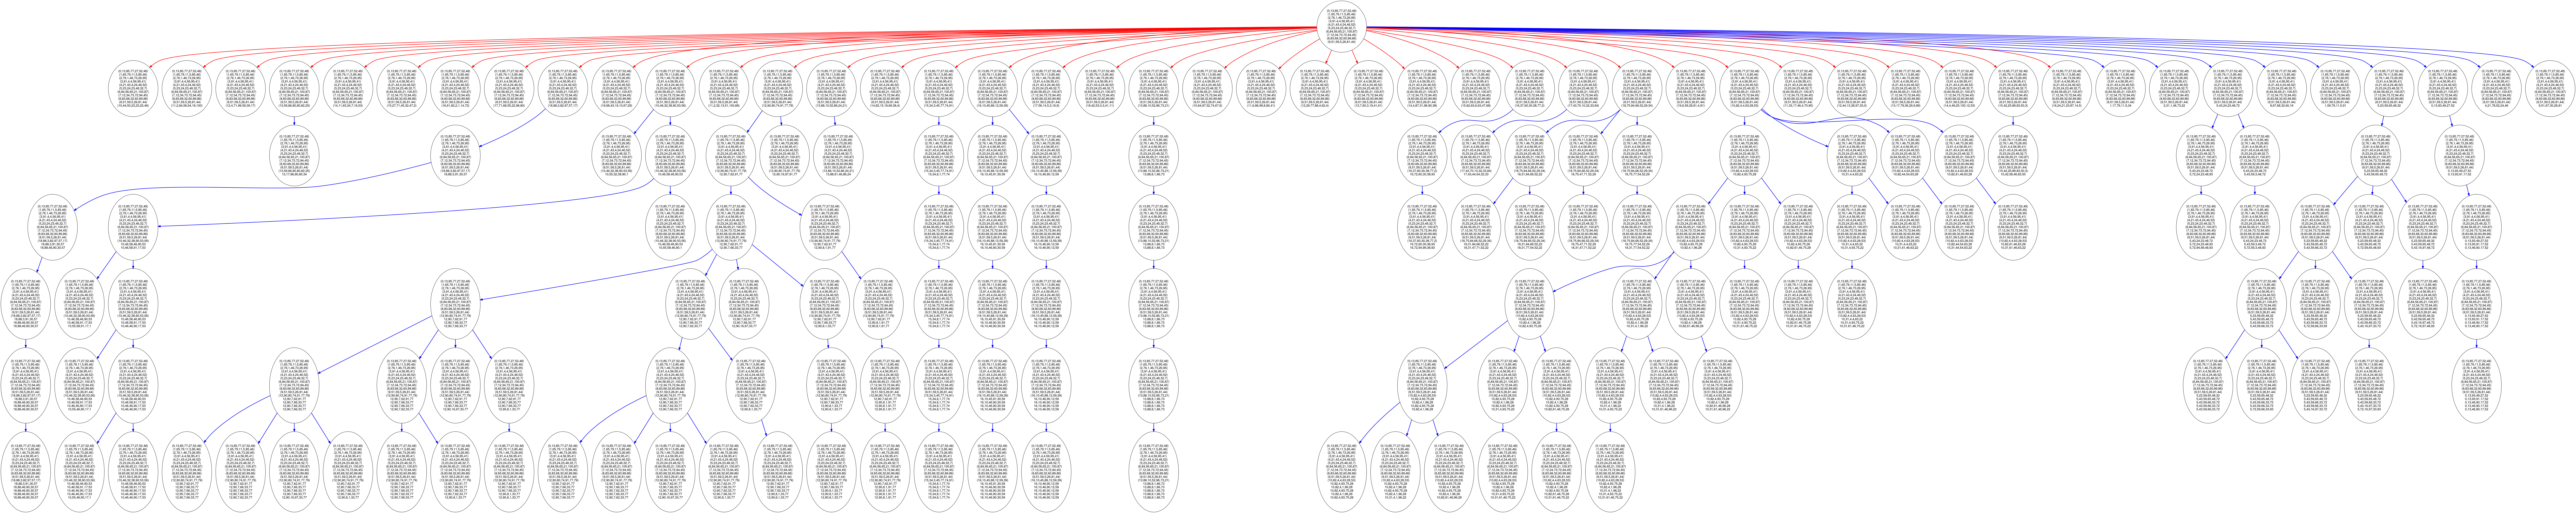

In [1517]:
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'

draw(G,'bigG.png')

In [1518]:
start = nodeDict['start']
startNode = '\n'.join(start)
startNode = nodeNameDict['start']
startNode = '\n'.join(nodeDict['""'])

nodeKeys = list(nodeDict.keys())
targetNum = 10
targets = []
for x in range(targetNum):
    targets.append(random.randint(0,len(nodeDict)-1))

targetPos = [nodeDict[nodeKeys[x]] for x in targets]
targetPos = ['\n'.join(x) for x in targetPos]
#targetNewFormat = ['\n'.join(t) for t in targetPos]

In [1519]:
nodelist = list(nodeDict.keys())
nodeList = [nodeDict[x] for x in nodelist]
graphNodeList = ['\n'.join(x) for x in nodeList]

pathLength = []
statyBojangles = []
for x in graphNodeList:
    singleStats = getGraphStats(G,x,startNode)
    statyBojangles.append(singleStats)
    pathLength.append(singleStats[-1])
    
longPath = max(pathLength)
smallPath = min(pathLength)
medianPath = int(np.median(pathLength))
nodeNum = G.number_of_nodes()
edgeNum = G.number_of_edges()

insertQueries = 0
updateQueries = 0
for x in queries:
    if 'INSERT' in x:
        insertQueries += 1
    if 'UPDATE' in x:
        updateQueries +=1
        
print(insertQueries,updateQueries)

results = '{} & {} & {} & {} & {}'.format(nodeNum,edgeNum,longPath,smallPath,medianPath)

with open('resultsDump2.txt','a') as f:
    f.write(names+'\n'+results+'\n'+testDataOG+'\n'+testQueries+'\n\n')

72 168


In [1497]:
print(results)

283 & 282 & 7 & 1 & 4


In [1498]:
timings.append(time.time()-t0) # Used to time each run of the code, needs updating for automation but for now 
                               # run the code from the first instance of t0 to here for each itteration to record timings

In [1499]:
print(timings)

[8.045547485351562, 8.266209602355957, 8.3679039478302, 8.573922634124756]


In [1500]:
np.mean(timings)

8.313395917415619

In [1501]:
for x in range(len(statyBojangles)):
    if statyBojangles[x][0] != 1:
        print(statyBojangles[x][0])

0
0


In [1502]:
def getGraphStats(G,target,start):
    allPaths = []
    #for sources in dataValuesNonStr:
    singlePath = []
    for path in nx.all_simple_paths(G,source=start,target=target):
        singlePath.append(path)
    allPaths.append(singlePath)
    APP = len(allPaths[0])
    
    allPSorted = sorted(allPaths[0])
    allPSet = set(frozenset(x) for x in allPSorted)
    DIFF = [list(x) for x in allPSet]
    DIFFNUM = len(DIFF)
    
    minPath = nx.shortest_path(G,start,target)
    smallpp = len(minPath)
    #bigpp = nx.dag_longest_path_length(G)
    
    return [APP,DIFFNUM,smallpp]#,bigpp]